# Imports

In [3]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
import numpy as np
import matplotlib.pyplot as plt

# Read Data

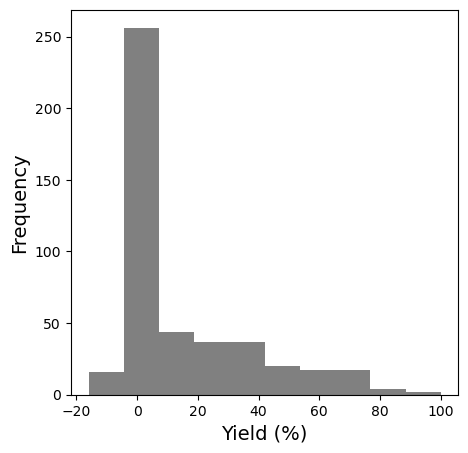

,Yield (%),x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x181,x182,x183,x184,x185,x186,x187,x188,x189,x190
R1_2,1.916534,-0.063670,1.784157,-0.206310,-0.023277,-0.114794,0.183033,0.036033,0.061658,-0.345264,...,6.572514,6.339063,7.850955,1.511892,6.407769,7.285463,6.908743,8.216943,1.308200,7.992698
R1_5,98.000000,-0.061351,1.816461,-0.218842,-0.030145,-0.124494,0.188697,0.041069,0.060353,-0.376125,...,6.497622,6.092458,7.055260,0.962802,6.376705,7.370445,7.021018,8.155038,1.134020,8.086289
R1_6,0.617317,-0.071244,1.780166,-0.209940,0.016420,-0.096760,0.226360,0.020681,0.083040,-0.388780,...,6.443564,6.443564,6.443564,0.000000,6.443564,6.952513,6.952513,6.952513,0.000000,6.952513
R1_8,0.851423,-0.067185,1.780165,-0.216880,0.036010,-0.090435,0.252890,0.016170,0.113990,-0.456130,...,4.894739,4.894739,4.894739,0.000000,4.894739,6.648917,6.648917,6.648917,0.000000,6.648917
R1_10,4.908090,-0.067275,1.781649,-0.217025,0.020780,-0.098122,0.237805,0.020244,0.090149,-0.396203,...,6.615313,6.374532,7.124679,0.750147,6.377288,7.056268,7.037797,7.146163,0.108366,7.099058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R5_796,-13.206800,-0.024164,1.903453,-0.257967,-0.078693,-0.168330,0.179275,0.079036,0.006817,-0.407675,...,6.954069,6.028940,7.391170,1.362230,6.086104,6.989464,6.925771,7.430007,0.504236,7.430007
R5_797,-12.784600,-0.024191,1.900147,-0.256970,-0.079570,-0.168270,0.177400,0.079805,0.011430,-0.415940,...,6.027940,6.027940,6.029321,0.001381,6.029321,6.909132,6.909131,6.918910,0.009778,6.918910
R5_798,-13.645200,-0.026401,1.900154,-0.254050,-0.079880,-0.166965,0.174170,0.080029,0.005780,-0.411720,...,6.034069,6.029424,6.034070,0.004646,6.034070,6.910345,6.910344,6.919218,0.008874,6.910344
R5_799,-10.548200,-0.041824,1.902125,-0.234732,-0.074462,-0.154597,0.160270,0.074580,0.027824,-0.397857,...,6.041513,6.039198,6.050017,0.010818,6.039198,6.954143,6.941776,6.999585,0.057808,6.941776


In [4]:
# This cell reads in parameters and response data from Excel files and combines them into a single dataframe
# It assumes a row of xID numbers, followed by a row of full parameter names
# Check cell outputs to make sure everything looks good

parameters_file = "Multi-Threshold Analysis Data" # Excel file to pull parameters from
parameters_sheet = "Suzuki Yields and Parameters" # Sheet in the Excel file to pull parameters from
parameters_start_col = 3   # 0-indexed column number where the parameters start
parameters_num_parameters = 190 # Number of parameters in the parameters file
parameters_num_responses = 450 # Number of responses/ligands in the parameters file
parameters_y_label_col = 0  # 0-indexed column number where the ligand labels are
parameters_header_rows = 0 # Number of rows to skip when reading the parameters

response_file = "Multi-Threshold Analysis Data" # Excel file to pull responses from
response_sheet = "Suzuki Yields and Parameters" # Sheet in the Excel file to pull responses from
response_num_samples = 450 # Number of samples/reactions in the response file
response_col = 1 # 0-indexed column number for the responses
response_y_label_col = 0  # 0-indexed column number where the ligand labels are
response_header_rows = 1 # Number of rows to skip when reading the responses

RESPONSE_LABEL = "Yield (%)" # How you want to refer to your response variable in the dataframe

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE
# --------------------------------------------------------------------------------------------------------------

# Actually start reading stuff into dataframes
parameters_df = pd.read_excel("./InputData/" + parameters_file + ".xlsx",
                              parameters_sheet,
                              header = parameters_header_rows,
                              index_col = parameters_y_label_col,
                              nrows = parameters_num_responses + 1,
                              usecols = list(range(0, (parameters_num_parameters + parameters_start_col)))
                              )
response_df = pd.read_excel("./InputData/" + response_file + ".xlsx",
                            response_sheet,
                            header = response_header_rows,
                            index_col = response_y_label_col,
                            nrows = response_num_samples,
                            usecols = list(range(0, response_col + 1))
                            )


# Drop any columns before parameters_start_col that are not the index column
parameters_columns_to_keep = [col for col in range(0, len(parameters_df.columns)) if col >= parameters_start_col-1]
parameters_df = parameters_df.iloc[:,parameters_columns_to_keep]

# Combine the two dataframes into the master dataframe
response_df.drop(response_df.columns[0:response_col-1], axis = 'columns', inplace = True)
data_df = response_df.merge(parameters_df, left_index = True, right_index = True)
data_df.columns.values[0] = RESPONSE_LABEL # Converts the output column name from whatever it is on the spreadsheet
data_df.dropna(inplace = True) # This covers the entire masking section and trims the dataframe down to only the rows relevant to this dataset

# This converts all the data to numeric values since it was reading them in as non-numeric objects for some reason
for column in data_df.columns:
    data_df[column] = pd.to_numeric(data_df[column], errors='coerce')

# Creates a dictionary to convert x# labels to full parameter names
parameter_names = list(parameters_df.iloc[0, :parameters_num_parameters])
parameter_x_labels = list(parameters_df.columns)[:parameters_num_parameters]
x_labelname_dict = dict(zip(parameter_x_labels, parameter_names))

# Print out the data distribution of the response variable
plt.figure(figsize=(5, 5))
plt.hist(data_df[RESPONSE_LABEL], color='grey')
plt.xlabel(RESPONSE_LABEL, fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.show()

# Display the dataframe
display(data_df)

# Cross Terms

## Full Cross-Terms Calculation

In [ ]:
# This cell appends all possible cross terms to the main dataframe

new_columns = {}

for parameter1 in parameter_x_labels:
    for parameter2 in parameter_x_labels:
        if parameter1 != parameter2:
            crossterm_id = parameter1 + " * " + parameter2
            new_columns[crossterm_id] = data_df[parameter1] * data_df[parameter2]
            x_labelname_dict[crossterm_id] = x_labelname_dict[parameter1] + " * " + x_labelname_dict[parameter2]

print(f'Number of cross terms: {len(new_columns)}')

cross_terms_df = pd.DataFrame(new_columns)
cross_terms_df = pd.concat([data_df, cross_terms_df], axis=1)

display(cross_terms_df)

## Limitted Cros-Terms Calculation

In [ ]:
# This cell appends all cross terms made from a subset of parameters to the main dataframe

parameters_to_cross = range(1, 50)
# parameters_to_cross = list(range(0, 10)) + list(range(20, 30)) # Example of how to cross a non-continuous subset of parameters

# --------------------------------------------------------------------------------------------------------------

parameters_to_cross = [f'x{i}' for i in parameters_to_cross]
print(f'Selected parameters: {parameters_to_cross}')

new_columns = {}

for parameter1 in parameters_to_cross:
    for parameter2 in parameters_to_cross:
        if parameter1 != parameter2:
            crossterm_id = parameter1 + " * " + parameter2
            new_columns[crossterm_id] = data_df[parameter1] * data_df[parameter2]
            x_labelname_dict[crossterm_id] = x_labelname_dict[parameter1] + " * " + x_labelname_dict[parameter2]

print(f'Number of cross terms: {len(new_columns)}')

cross_terms_df = pd.DataFrame(new_columns)
cross_terms_df = pd.concat([data_df, cross_terms_df], axis=1)

display(cross_terms_df)

## Cross-Terms Between Ranges

In [ ]:
# This cell appends all cross terms made by crossing two subsets of parameters to the main dataframe

parameters_to_cross_1 = range(1, 10)
parameters_to_cross_2 = range(20, 30)

# --------------------------------------------------------------------------------------------------------------

parameters_to_cross_1 = [f'x{i}' for i in parameters_to_cross_1]
parameters_to_cross_2 = [f'x{i}' for i in parameters_to_cross_2]
print(f'Selected parameters 1: {parameters_to_cross_1}')
print(f'Selected parameters 2: {parameters_to_cross_2}')

new_columns = {}

for parameter1 in parameters_to_cross_1:
    for parameter2 in parameters_to_cross_2:
        if parameter1 != parameter2:
            crossterm_id = parameter1 + " * " + parameter2
            new_columns[crossterm_id] = data_df[parameter1] * data_df[parameter2]
            x_labelname_dict[crossterm_id] = x_labelname_dict[parameter1] + " * " + x_labelname_dict[parameter2]

print(f'Number of cross terms: {len(new_columns)}')

cross_terms_df = pd.DataFrame(new_columns)
cross_terms_df = pd.concat([data_df, cross_terms_df], axis=1)

display(cross_terms_df)

## Export Cross-Terms Dataframe

In [ ]:
# This will export the dataframe to an Excel file in the InputData folder
# It will add a blank row between the column names and the data due to how it handles the MultiIndex, so you may want to delete that row before using the data

export_filename = 'cross_terms.xlsx'

# --------------------------------------------------------------------------------------------------------------

output_df = cross_terms_df.copy()
fancy_column_names = pd.MultiIndex.from_tuples([(col, x_labelname_dict[col]) if col in x_labelname_dict else (col, col) for col in output_df.columns])
output_df.columns = fancy_column_names

output_df.to_excel(f'InputData/{export_filename}')

# Boruta Feature Selection

In [ ]:
# Initialize and fit the Boruta feature selector
# Basically all of the arguments here are default so you might play around with them to suit your needs
# Once you get up into the 1000s of features, it might take a while to run, especially if you're using the full cross-term dataset

# Only use one of the following lines
boruta_df = data_df.copy() # If you want to use the original data
# boruta_df = cross_terms_df.copy() # If you want to use the data with cross terms

rf = RandomForestRegressor(n_jobs=-1, max_depth=5) # I might take a look at max_depth

# {perc} is the percentage of the maximum importance of the shadow features to set as the cutoff
    # Lower {perc} means you'll get more false positive features kept, but are less likely to discard relevant features
# {max_iter} is the maximum number of iterations to run before stopping
    # Let it go longer if you want to fully resolve the tentative features
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1, perc=75, max_iter=199) 

parameter_columns = [col for col in boruta_df.columns if col in x_labelname_dict.keys()]
feat_selector.fit(np.asarray(boruta_df[parameter_columns]), np.asarray(boruta_df[RESPONSE_LABEL]))

# Compile the xIDs of confirmed and tentatively accepted features into a list
xIDs_confirmed = [parameter_columns[i] for i in range(0,len(feat_selector.support_)) if feat_selector.support_[i]]
xIDs_tentative = [parameter_columns[i] for i in range(0,len(feat_selector.support_)) if feat_selector.support_weak_[i]]
xIDs_confirmed.extend(xIDs_tentative)

boruta_df_output = boruta_df[[column for column in boruta_df.columns if column in xIDs_confirmed]]
display(boruta_df_output)

## Export Boruta Dataframe

In [ ]:
# This will export the dataframe to an Excel file in the InputData folder
# It will add a blank row between the column names and the data due to how it handles the MultiIndex, so you may want to delete that row before using the data

export_filename = 'boruta.xlsx'

# --------------------------------------------------------------------------------------------------------------

output_df = boruta_df_output.copy()
fancy_column_names = pd.MultiIndex.from_tuples([(col, x_labelname_dict[col]) if col in x_labelname_dict else (col, col) for col in output_df.columns])
output_df.columns = fancy_column_names

output_df.to_excel(f'InputData/{export_filename}')